# Check lfp-derived spikes

TODO: 

* Find out how to get cell's soma trace?
* pretty print the config with indents

## Setup

In [2]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os 

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)
from src.nodes.waveforms import get_waveforms, plot_waveforms

# SETUP DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = "/gpfs/bbp.cscs.ch/data/scratch/proj68/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/spiketrains.pkl"
LFP_TRACE_FILE_PATH = "/gpfs/bbp.cscs.ch/data/scratch/proj68/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/traces.pkl"
CELL_TRACE_FILE_PATH = "/gpfs/bbp.cscs.ch/data/scratch/proj68/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/cells/cell_3754013_trace.pkl"

# SETUP PARAMETERS
CELL_ID = 3754013
CHANNEL_ID = [71]

# trace period
MIN_TIME = 540 # ms
MAX_TIME = 620 # ms

## Load data

In [2]:
spike = pd.read_pickle(SPIKE_FILE_PATH)
lfp_trace = pd.read_pickle(LFP_TRACE_FILE_PATH)
cell_trace = pd.read_pickle(CELL_TRACE_FILE_PATH)

## A pyr. cell's spikes with channel 55's LFP trace

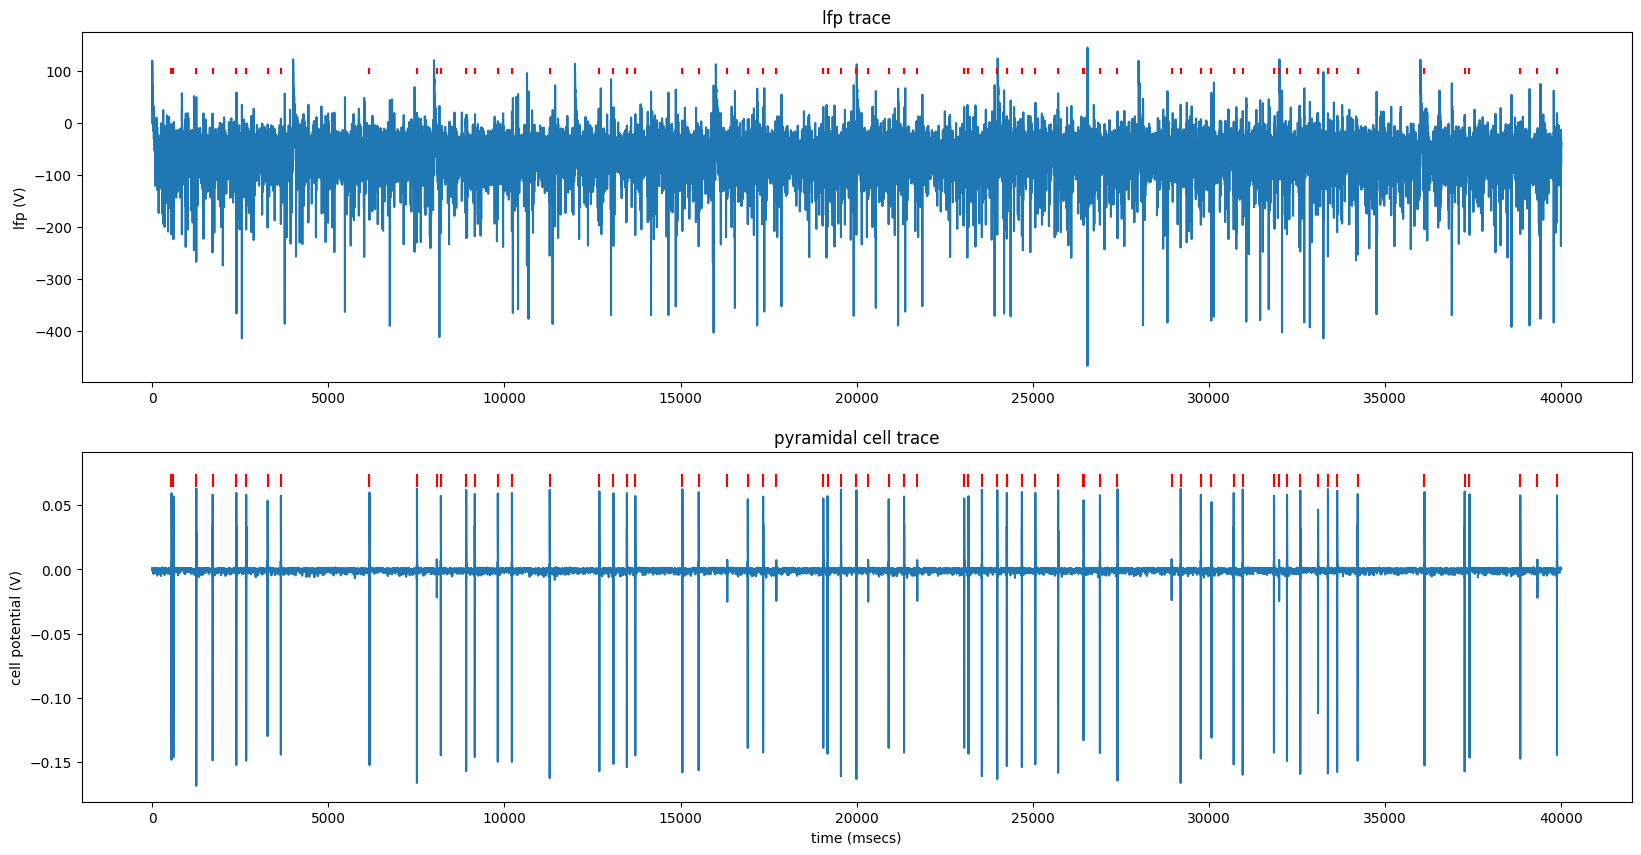

In [3]:
fig, axes = plt.subplots(2,1, figsize=(20,10))
axes[0].plot(lfp_trace.index, lfp_trace[CHANNEL_ID[0]])
axes[0].eventplot(spike[spike==CELL_ID].index, linelengths=10, lineoffsets=100, colors="r");
axes[0].set_title("lfp trace");
axes[0].set_ylabel("lfp (V)");

axes[1].plot(cell_trace.index, cell_trace[CHANNEL_ID[0]])
axes[1].eventplot(spike[spike==CELL_ID].index, linelengths=0.01, lineoffsets=max(cell_trace[CHANNEL_ID[0]])*1.1, colors="r");
axes[1].set_title("pyramidal cell trace");
axes[1].set_ylabel("cell potential (V)");
plt.xlabel("time (msecs)");

### Zoom in 

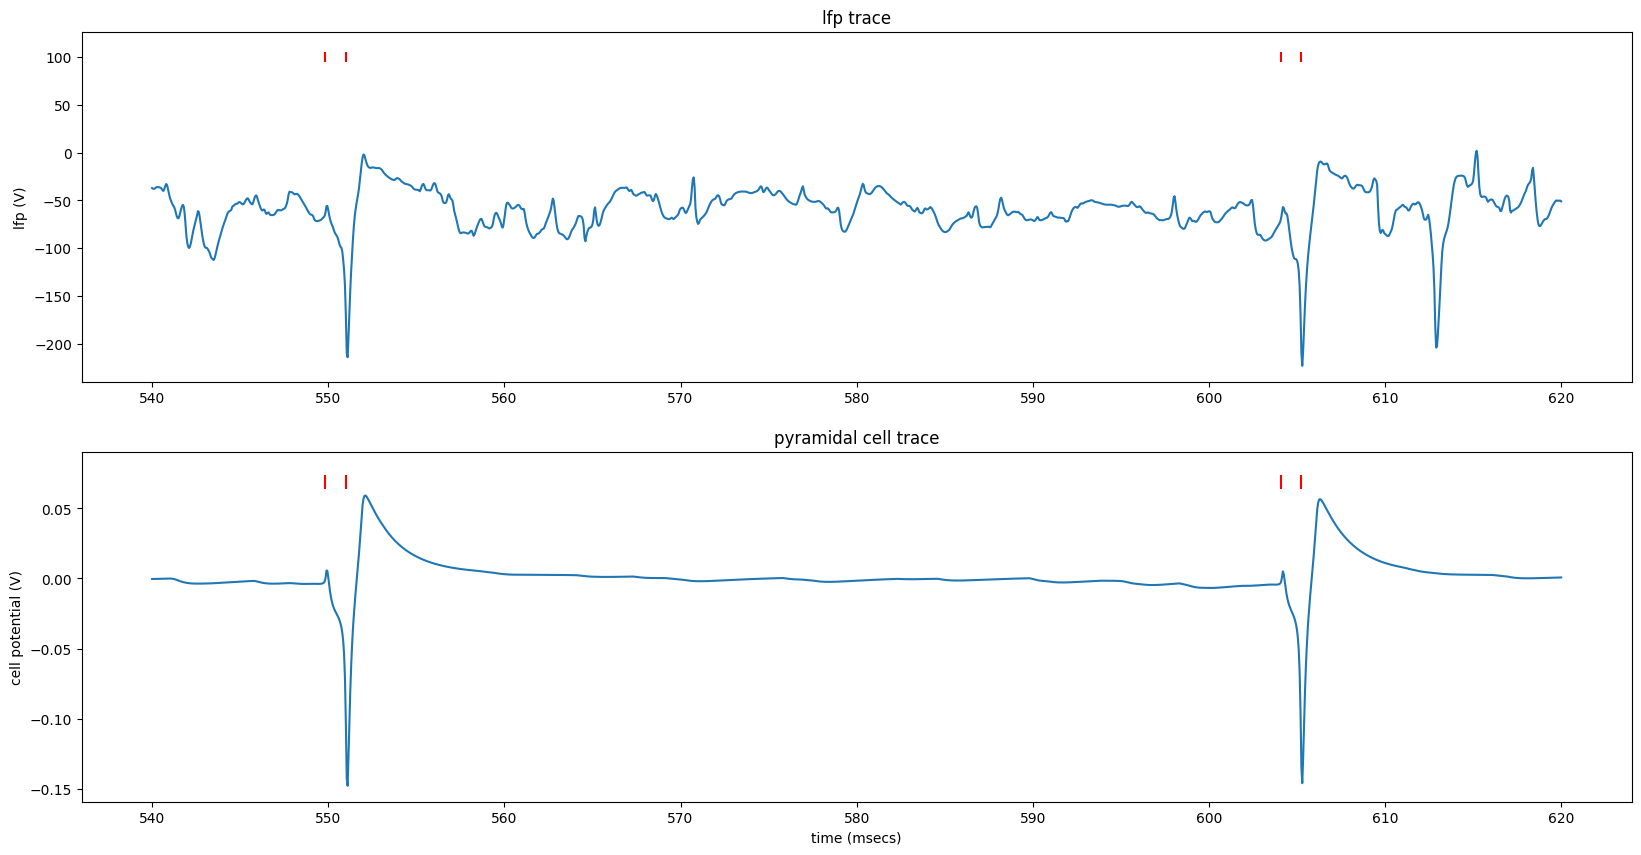

In [4]:
fig, axes = plt.subplots(2,1, figsize=(20,10))

# calculate period
period = np.logical_and(lfp_trace.index > MIN_TIME, lfp_trace.index < MAX_TIME)
spike_period = spike[spike==CELL_ID].index < MAX_TIME

# lfp trace and spikes
axes[0].plot(lfp_trace.index[period], lfp_trace[CHANNEL_ID[0]].loc[period])
axes[0].eventplot(spike[spike==CELL_ID].index[spike_period], linelengths=10, lineoffsets=100, colors="r");
axes[0].set_title("lfp trace");
axes[0].set_ylabel("lfp (V)");

# cell trace
axes[1].plot(cell_trace.index[period], cell_trace[CHANNEL_ID[0]].loc[period])
axes[1].eventplot(spike[spike==CELL_ID].index[spike_period], linelengths=0.01, lineoffsets=max(cell_trace[CHANNEL_ID[0]])*1.1, colors="r");
axes[1].set_title("pyramidal cell trace");
axes[1].set_ylabel("cell potential (V)");
plt.xlabel("time (msecs)");

### Waveforms (custom-code)

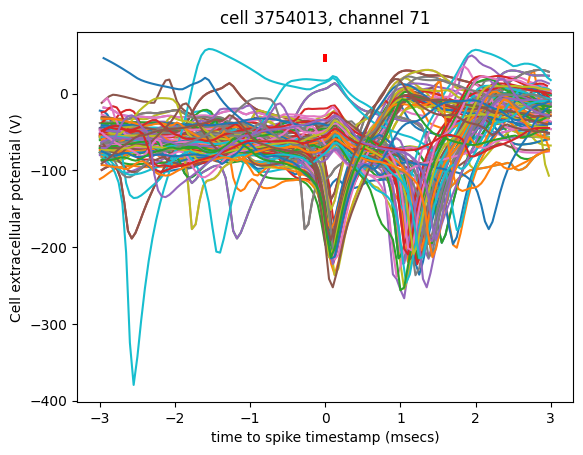

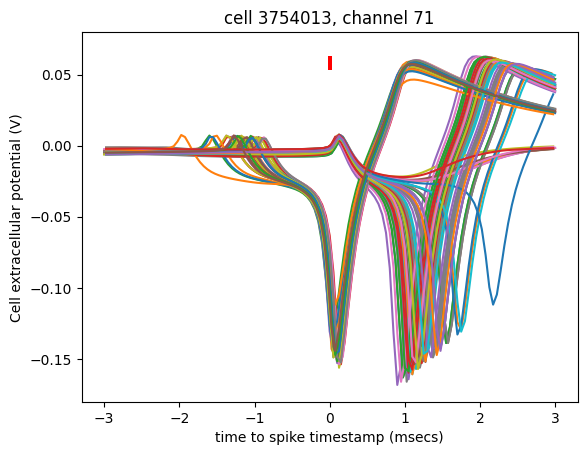

In [4]:
# trace period
MIN_TIME = 0        # ms
MAX_TIME = 40000    # ms

# period around spike
MS_BEFORE = 3       # ms
MS_AFTER = 3        # ms
SAMPLING_FREQ = 20000

# compute and plot waveforms from lfp trace
out = get_waveforms(cell_id=CELL_ID, spikes=spike, trace=lfp_trace, channel_id=CHANNEL_ID[0], ms_before=MS_BEFORE, ms_after=MS_AFTER, min_time=MIN_TIME, max_time=MAX_TIME)
plot_waveforms(out["spikes"], out["waveforms"], out["timestamps"], title=f"cell {CELL_ID}, channel {CHANNEL_ID[0]}", linelengths=10)
plt.show()

# compute and plot waveforms from cell trace
out = get_waveforms(cell_id=CELL_ID, spikes=spike, trace=cell_trace, channel_id=CHANNEL_ID[0], ms_before=MS_BEFORE, ms_after=MS_AFTER, min_time=MIN_TIME, max_time=MAX_TIME)
plot_waveforms(out["spikes"], out["waveforms"], out["timestamps"], title=f"cell {CELL_ID}, channel {CHANNEL_ID[0]}", linelengths=0.01)
plt.show()

### Waveforms (SpikeInterface method)

In [5]:
%load_ext autoreload
%autoreload 2

from src.nodes.simulation.dataeng.filtering import get_cell_spiking_above_thresh, get_cell_id_spiking_above_thresh, create_study_object, filter_microcircuit_cells
import spikeinterface.full as sifull
import spikeinterface as si
from src.nodes import viz
from spikeinterface.comparison import GroundTruthStudy
import shutil
from src.pipelines.simulation.sorting import ground_truth
from src.pipelines.simulation.dataeng.loading import load_campaign_params
from src.nodes.utils import get_config
from src.pipelines.simulation.preprocessing import preprocess
from src.pipelines.simulation import recording

SIMULATION_DATE = "2023_01_13"
PLOT_OPTIONS = "save_only"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_study'
MIN_SPIKE = 10

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def plot_waveform_for(cell_ids:list, true_spike:si.core.unitsselectionsorting, trace: si.preprocessing, min_spike:int, study_folder:str, **kwargs:dict):
    """Plot best waveform for a chosen set of cell_ids

    Args:
        cell_ids (list): Cell global identifiers (gids)
        GroundTruthSpike (_type_): _description_
    """
    # select cell ground truth spikes
    true_spike = true_spike.select_units(cell_ids)

    # select active cell spking
    true_spike = get_cell_spiking_above_thresh(true_spike, min_spike=min_spike)
    print(len(true_spike.unit_ids))

    # bundle spike and trace data for study
    study_object = create_study_object(trace, true_spike)

    # extract waveforms
    waveform_extractor = viz.get_waveform_extractor_and_ground_truth(study_object, study_folder=study_folder)

    # plot
    viz.plot_neuron_best_waveform(trace, true_spike, waveform_extractor, study_folder=study_folder, **kwargs)

In [115]:
# get config
data_conf, param_conf = get_config(SIMULATION_DATE).values()

# load campaign parameters
simulation = load_campaign_params(data_conf, param_conf)

# load lfp traces
lfp_traces2 = preprocess.run(data_conf, param_conf)

# get microcircuit's 30K cells
microcircuit_cells = filter_microcircuit_cells(simulation)
print("Microcircuit cells (count): ", len(microcircuit_cells["gid"]))

# get spikes
output = ground_truth.run(simulation, data_conf, param_conf)
SortingObject = output["ground_truth_sorting_object"]

# # move back to project path
# os.chdir("../../")

2023-01-24 11:01:11,265 - root - utils.py - get_config - INFO - Loaded config
2023-01-24 11:01:22,181 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
2023-01-24 11:01:32,465 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
write_binary_recording with n_jobs = 1 and chunk_size = None
Microcircuit cells (count):  30190


This below is wrong. Why?

1
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


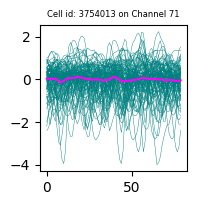

In [8]:
# compute and save plots
plot_waveform_for(
    cell_ids=[CELL_ID],
    true_spike=SortingObject, 
    trace=lfp_traces2, 
    min_spike=MIN_SPIKE, 
    study_folder=STUDY_FOLDER, 
    plot_options="show"
    )

**Hypothesis**: lfp_traces2 signal is differnet from lfp_trace - NOPE

- lfp_traces2.get_times() are wrong. divided by 1000 compared with lfp trace but nothing changes after setting it up write

/gpfs/bbp.cscs.ch/home/laquitai/.local/lib/python3.9/site-packages/spikeinterface/core/baserecording.py:194: UserWarning: Setting times with Recording.set_times() is not recommended because times are not always propagated to across preprocessingUse use this carefully!
  warn('Setting times with Recording.set_times() is not recommended because '


[0.000000e+00 5.000000e-02 1.000000e-01 ... 3.999985e+04 3.999990e+04
 3.999995e+04]
1
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


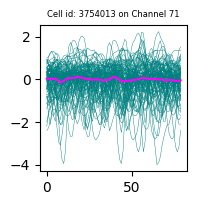

In [135]:
# set times right
lfp_traces2.set_times(lfp_trace.index)
print(lfp_traces2.get_times())

# compute and save plots
plot_waveform_for(
    cell_ids=[CELL_ID],
    true_spike=SortingObject, 
    trace=lfp_traces2, 
    min_spike=MIN_SPIKE, 
    study_folder=STUDY_FOLDER, 
    plot_options="show"
    )

**Hypothesis**: preprocessing has corrupted the signal and we will not be able to recover the waveforms we had with lfp_trace - NOPE

In [ ]:
# format lfp_trace2 same as lfp_trace
lfp_traces2_df = pd.DataFrame(lfp_traces2.get_traces(), index=lfp_trace.index, columns=lfp_trace.columns)

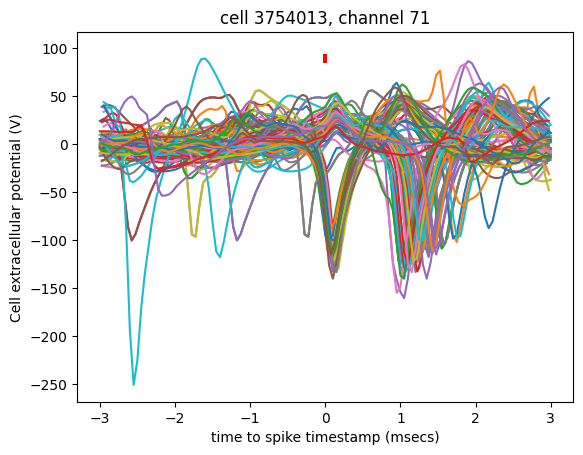

In [134]:
# trace period
MIN_TIME = 0        # ms
MAX_TIME = 40000    # ms

# period around spike
MS_BEFORE = 3       # ms
MS_AFTER = 3        # ms
SAMPLING_FREQ = 20000

# compute and plot waveforms from lfp trace
out = get_waveforms(cell_id=CELL_ID, spikes=spike, trace=lfp_traces2_df, channel_id=CHANNEL_ID[0], ms_before=MS_BEFORE, ms_after=MS_AFTER, min_time=MIN_TIME, max_time=MAX_TIME)
plot_waveforms(out["spikes"], out["waveforms"], out["timestamps"], title=f"cell {CELL_ID}, channel {CHANNEL_ID[0]}", linelengths=10)
plt.show()

## TODO

- Solve jitter issue in waveforms, probably caused by conversion from spike sample to trace samples timepoints

In [9]:
# get raw traces
lfp_trace3 = recording.run(data_conf, param_conf)

2023-01-24 09:16:46,938 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/


In [10]:
# format spikes and traces
test_spikes = SortingObject.get_unit_spike_train(CELL_ID)
test_traces = pd.DataFrame(data=lfp_trace3.get_traces(), index=lfp_trace3.get_times()*1000, columns=lfp_trace3.get_channel_ids())

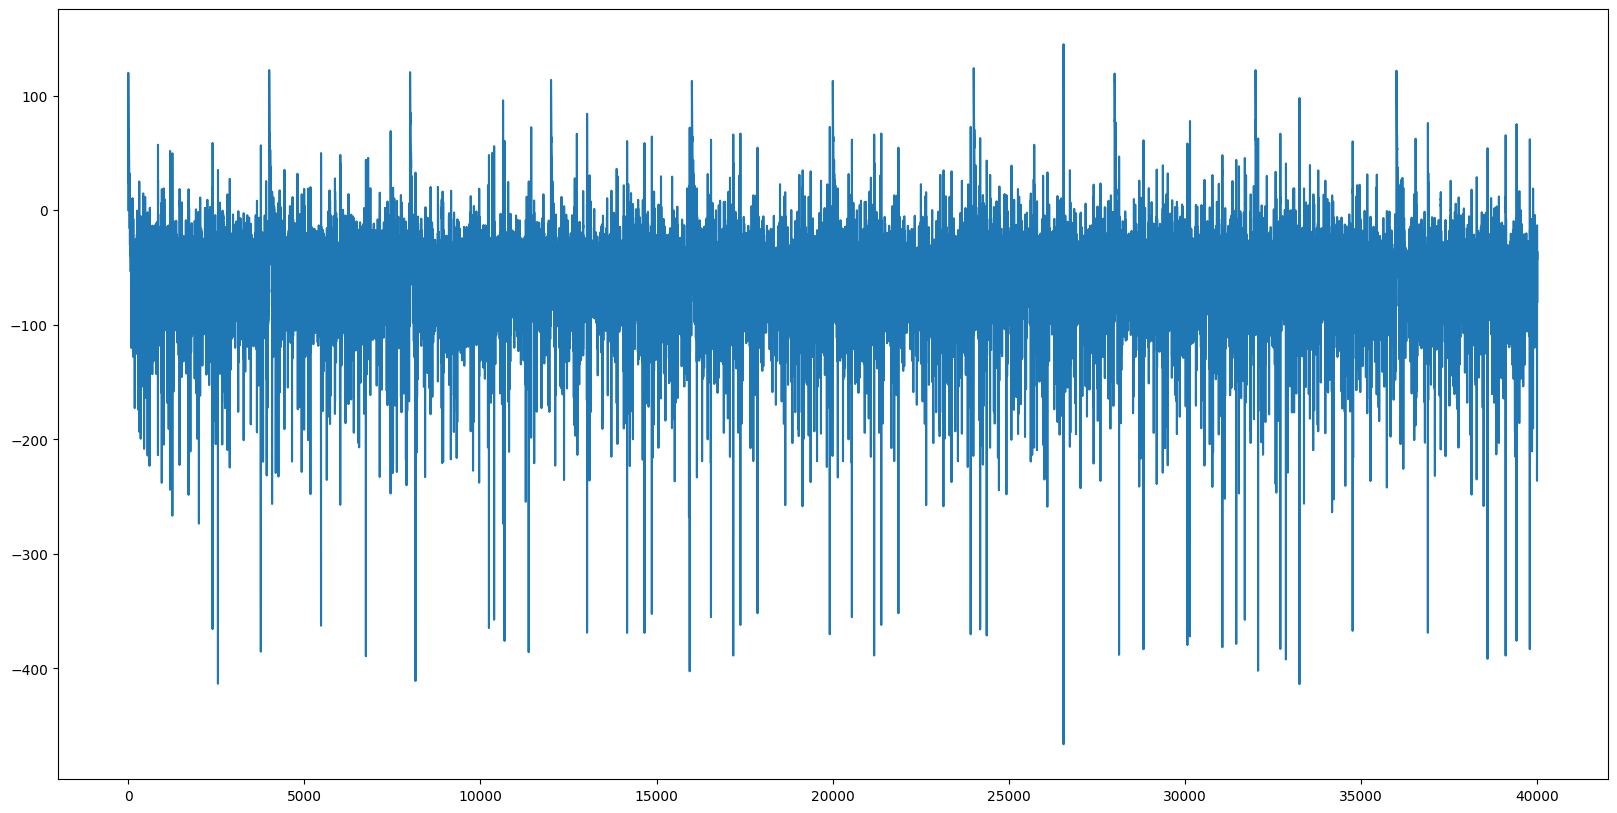

In [11]:
fig = plt.figure(figsize=(20,10))
plt.plot(test_traces[71]);

In [13]:
test_spikes[test_spikes > sum(period)]

array([ 10996,  11020,  12082,  12104,  25060,  34350,  34374,  47773,
        47796,  53378,  53403,  65527,  65561,  73074,  73102, 123384,
       123408, 150338, 161622, 163896, 163924, 178281, 183169, 183192,
       196228, 196249, 204238, 204260, 225703, 253884, 261877, 261899,
       269519, 269540, 274300, 274326, 301032, 310276, 310297, 326521,
       338138, 338167, 346871, 346899, 354383, 381013, 381043, 383452,
       383474, 391067, 399815, 406521, 418138, 418167, 426871, 426899,
       434383, 461013, 461043, 463452, 463474, 471067, 479815, 485221,
       485244, 493776, 493796, 501396, 501418, 514365, 528783, 528816,
       538084, 538111, 548090, 578821, 583914, 595379, 595405, 601404,
       601438, 614022, 614046, 619152, 636898, 636925, 639841, 644287,
       644314, 651840, 661896, 661938, 667537, 672773, 684426, 684451,
       722362, 722382, 745158, 747903, 747926, 776725, 776752, 786470,
       797577, 797605])

Zoom in

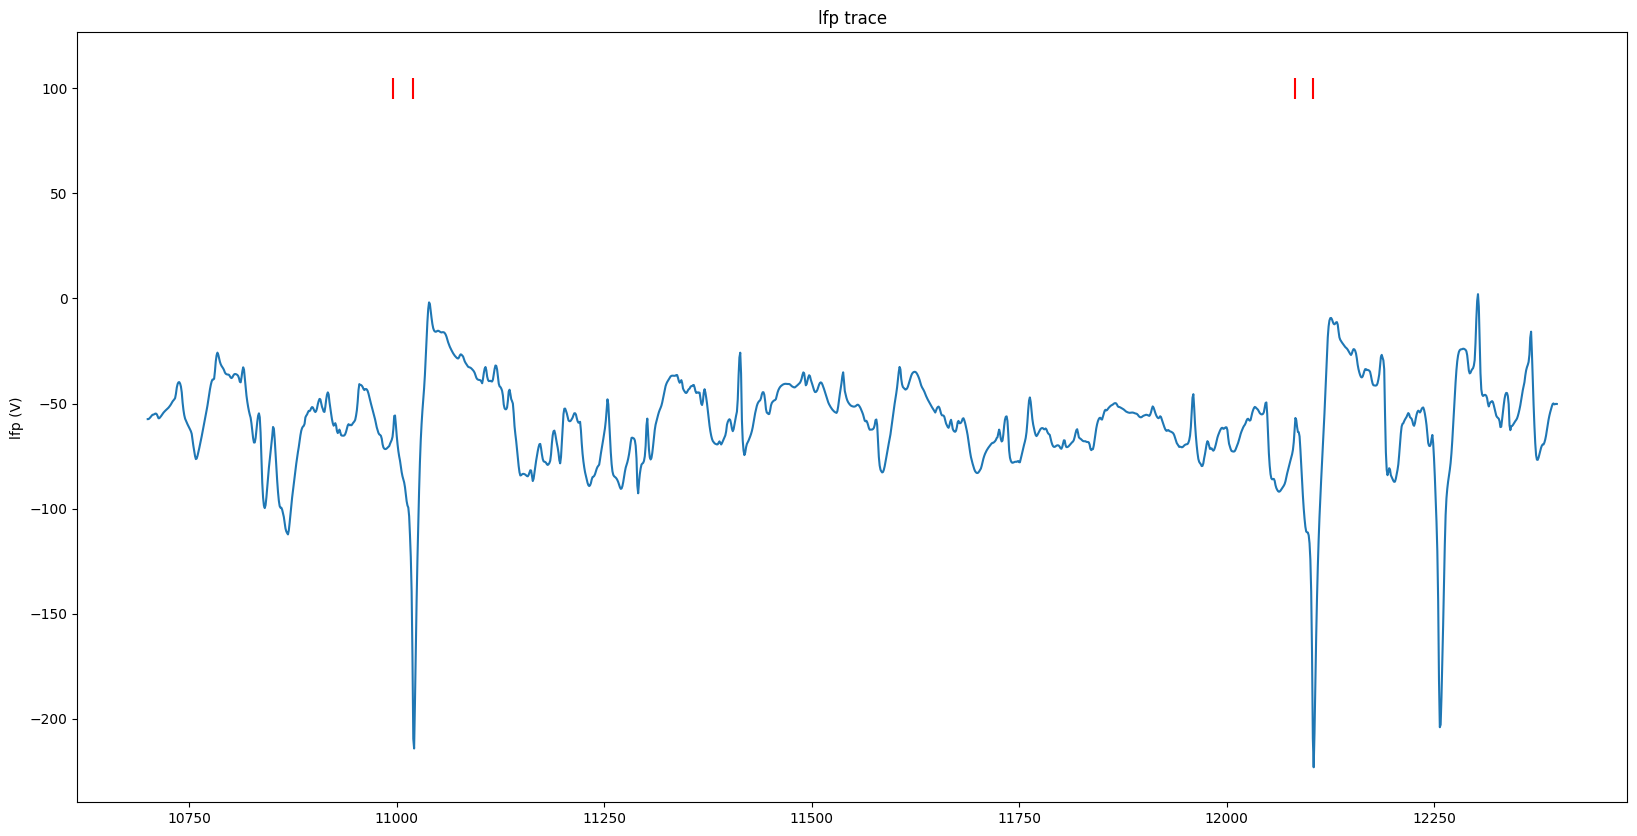

In [14]:
MIN_TIME = 0
MAX_TIME = 620

fig = plt.figure(figsize=(20,10))

# calculate period
period = np.logical_and(test_traces.index > MIN_TIME, test_traces.index < MAX_TIME)
spike_period = test_spikes / simulation["lfp_sampling_freq"] * 1000 < MAX_TIME

# lfp trace and spikes
plt.plot(np.arange(10700,sum(period),1), test_traces[CHANNEL_ID[0]].iloc[np.arange(10700,sum(period),1)])
plt.eventplot(test_spikes[test_spikes < sum(period)], linelengths=10, lineoffsets=100, colors="r");
plt.title("lfp trace");
plt.ylabel("lfp (V)");

check waveforms derived from lfp trace

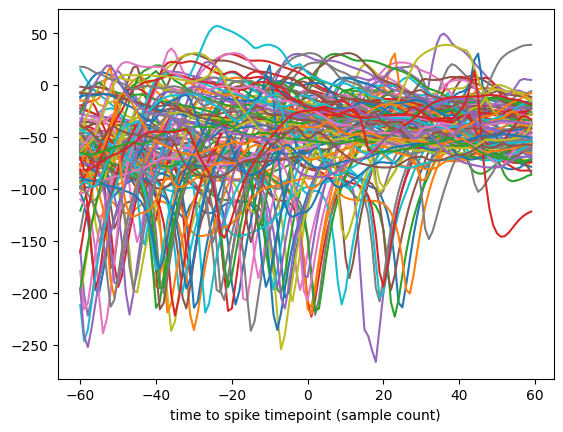

In [139]:
true_spikes = spike[spike==CELL_ID]

spike_loc = np.int_(
        np.array(true_spikes.index) * simulation["lfp_sampling_freq"] / 1000
    )
true_spikes = np.array(spike_loc)

x_axis_all =[]
for spike_i in true_spikes:
    x_axis = np.arange(spike_i-60, spike_i+60, 1) - spike_i
    plt.plot(x_axis, test_traces[71].iloc[spike_i-60:spike_i+60])
    x_axis_all.append(x_axis)
plt.xlabel("time to spike timepoint (sample count)");

check derived from cell trace

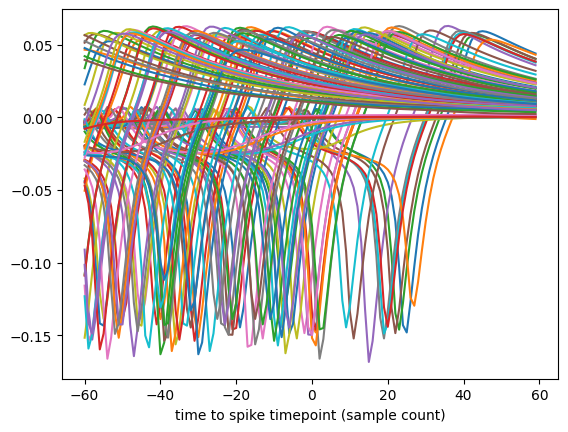

In [140]:
true_spikes = spike[spike==CELL_ID]
spike_loc = np.int_(
        np.array(true_spikes.index) * simulation["lfp_sampling_freq"] / 1000
    )
true_spikes = np.array(spike_loc)

si_waveform_locations = []
for spike_i in true_spikes:
    x_axis = np.arange(spike_i-60, spike_i+60, 1) - spike_i
    waveform_location = np.arange(spike_i-60, spike_i+60, 1)
    plt.plot(x_axis, cell_trace[71].iloc[spike_i-60:spike_i+60])
plt.xlabel("time to spike timepoint (sample count)");

array([10959, 10960, 10961, 10962, 10963, 10964, 10965, 10966, 10967,
       10968, 10969, 10970, 10971, 10972, 10973, 10974, 10975, 10976,
       10977, 10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985,
       10986, 10987, 10988, 10989, 10990, 10991, 10992, 10993, 10994,
       10995, 10996, 10997, 10998, 10999, 11000, 11001, 11002, 11003,
       11004, 11005, 11006, 11007, 11008, 11009, 11010, 11011, 11012,
       11013, 11014, 11015, 11016, 11017, 11018, 11019, 11020, 11021,
       11022, 11023, 11024, 11025, 11026, 11027, 11028, 11029, 11030,
       11031, 11032, 11033, 11034, 11035, 11036, 11037, 11038, 11039,
       11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048,
       11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057,
       11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066,
       11067, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075,
       11076, 11077, 11078])

array([10960, 10961, 10962, 10963, 10964, 10965, 10966, 10967, 10968,
       10969, 10970, 10971, 10972, 10973, 10974, 10975, 10976, 10977,
       10978, 10979, 10980, 10981, 10982, 10983, 10984, 10985, 10986,
       10987, 10988, 10989, 10990, 10991, 10992, 10993, 10994, 10995,
       10996, 10997, 10998, 10999, 11000, 11001, 11002, 11003, 11004,
       11005, 11006, 11007, 11008, 11009, 11010, 11011, 11012, 11013,
       11014, 11015, 11016, 11017, 11018, 11019, 11020, 11021, 11022,
       11023, 11024, 11025, 11026, 11027, 11028, 11029, 11030, 11031,
       11032, 11033, 11034, 11035, 11036, 11037, 11038, 11039, 11040,
       11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049,
       11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058,
       11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067,
       11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076,
       11077, 11078, 11079])

In [27]:
spike_loc = int(len(out["waveform_locations"][5])/2)
out["waveform_locations"][5][spike_loc]

print(out["waveform_locations"][5][0])
print(spike_loc)
print(out["waveform_locations"][5][spike_loc])

34286
60
34346


In [39]:
spike_loc = int(len(si_waveform_locations[5])/2)
print(si_waveform_locations[5][0])
print(spike_loc)
print(si_waveform_locations[5][spike_loc])

34290
60
34350


In [46]:
out["spikes"]

Float64Index([           549.825,            551.025,              604.1,
                           605.2,             1253.0,           1717.525,
                        1718.725,           2388.675,             2389.8,
                        2668.925,
              ...
              36118.100000052065, 36119.100000052065,  37257.92500005206,
               37395.15000005207, 37396.325000052064,  38836.27500005207,
               38837.62500005207,  39323.52500005207,  39878.87500005207,
               39880.27500005207],
             dtype='float64', name='t', length=106)

In [61]:
spike_ms = spike[spike==CELL_ID]
spike_ms.index[15]

6169.225000005787

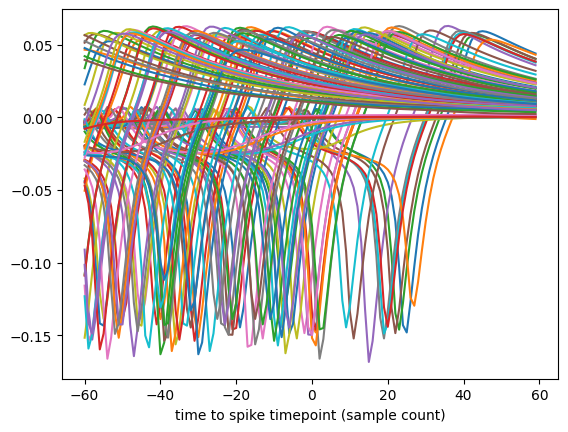

In [145]:
spike_ms = spike[spike==CELL_ID]
spike_loc = np.int_(
        np.array(spike_ms.index) * simulation["lfp_sampling_freq"] / 1000
    )
spike_ms = np.array(spike_loc)

si_waveform_locations = []
for spike_i in spike_ms:
    x_axis = np.arange(spike_i-60, spike_i+60, 1) - spike_i
    waveform_location = np.arange(spike_i-60, spike_i+60, 1)
    si_waveform_locations.append(waveform_location)
    plt.plot(x_axis, cell_trace[71].iloc[spike_i-60:spike_i+60])
plt.xlabel("time to spike timepoint (sample count)");

In [64]:
# Where we should be !
# get method's 1 (custom) target waveform locations
out["waveform_locations"][15]

array([123309, 123310, 123311, 123312, 123313, 123314, 123315, 123316,
       123317, 123318, 123319, 123320, 123321, 123322, 123323, 123324,
       123325, 123326, 123327, 123328, 123329, 123330, 123331, 123332,
       123333, 123334, 123335, 123336, 123337, 123338, 123339, 123340,
       123341, 123342, 123343, 123344, 123345, 123346, 123347, 123348,
       123349, 123350, 123351, 123352, 123353, 123354, 123355, 123356,
       123357, 123358, 123359, 123360, 123361, 123362, 123363, 123364,
       123365, 123366, 123367, 123368, 123369, 123370, 123371, 123372,
       123373, 123374, 123375, 123376, 123377, 123378, 123379, 123380,
       123381, 123382, 123383, 123384, 123385, 123386, 123387, 123388,
       123389, 123390, 123391, 123392, 123393, 123394, 123395, 123396,
       123397, 123398, 123399, 123400, 123401, 123402, 123403, 123404,
       123405, 123406, 123407, 123408, 123409, 123410, 123411, 123412,
       123413, 123414, 123415, 123416, 123417, 123418, 123419, 123420,
      

In [41]:
# what we calculate
# np.arange(11020.5-60, 11020.5+60,1)
np.arange(12082-60, 12082+60,1)

array([12022, 12023, 12024, 12025, 12026, 12027, 12028, 12029, 12030,
       12031, 12032, 12033, 12034, 12035, 12036, 12037, 12038, 12039,
       12040, 12041, 12042, 12043, 12044, 12045, 12046, 12047, 12048,
       12049, 12050, 12051, 12052, 12053, 12054, 12055, 12056, 12057,
       12058, 12059, 12060, 12061, 12062, 12063, 12064, 12065, 12066,
       12067, 12068, 12069, 12070, 12071, 12072, 12073, 12074, 12075,
       12076, 12077, 12078, 12079, 12080, 12081, 12082, 12083, 12084,
       12085, 12086, 12087, 12088, 12089, 12090, 12091, 12092, 12093,
       12094, 12095, 12096, 12097, 12098, 12099, 12100, 12101, 12102,
       12103, 12104, 12105, 12106, 12107, 12108, 12109, 12110, 12111,
       12112, 12113, 12114, 12115, 12116, 12117, 12118, 12119, 12120,
       12121, 12122, 12123, 12124, 12125, 12126, 12127, 12128, 12129,
       12130, 12131, 12132, 12133, 12134, 12135, 12136, 12137, 12138,
       12139, 12140, 12141])

In [57]:
# where we are
si_waveform_locations[15]

array([123324, 123325, 123326, 123327, 123328, 123329, 123330, 123331,
       123332, 123333, 123334, 123335, 123336, 123337, 123338, 123339,
       123340, 123341, 123342, 123343, 123344, 123345, 123346, 123347,
       123348, 123349, 123350, 123351, 123352, 123353, 123354, 123355,
       123356, 123357, 123358, 123359, 123360, 123361, 123362, 123363,
       123364, 123365, 123366, 123367, 123368, 123369, 123370, 123371,
       123372, 123373, 123374, 123375, 123376, 123377, 123378, 123379,
       123380, 123381, 123382, 123383, 123384, 123385, 123386, 123387,
       123388, 123389, 123390, 123391, 123392, 123393, 123394, 123395,
       123396, 123397, 123398, 123399, 123400, 123401, 123402, 123403,
       123404, 123405, 123406, 123407, 123408, 123409, 123410, 123411,
       123412, 123413, 123414, 123415, 123416, 123417, 123418, 123419,
       123420, 123421, 123422, 123423, 123424, 123425, 123426, 123427,
       123428, 123429, 123430, 123431, 123432, 123433, 123434, 123435,
      

In [84]:
# get target spike location
target_spike_loc = []
current_spike_loc = []
for ix in range(len(out["waveform_locations"])):
    target_spike_loc.append(out["waveform_locations"][ix][0] + 60)
    current_spike_loc.append(si_waveform_locations[ix][0] + 60)

np.array(target_spike_loc) - np.array(current_spike_loc)
target_spike_loc

[10995,
 11019,
 12080,
 12102,
 25057,
 34346,
 34370,
 47767,
 47790,
 53372,
 53395,
 65518,
 65552,
 73065,
 73092,
 123369,
 123393,
 150319,
 161602,
 163876,
 163903,
 178259,
 183146,
 183169,
 196204,
 196225,
 204213,
 204235,
 225674,
 253852,
 261844,
 261866,
 269485,
 269506,
 274266,
 274292,
 300994,
 310236,
 310258,
 326480,
 338096,
 338125,
 346828,
 346856,
 354339,
 380966,
 380996,
 383403,
 383426,
 391017,
 399765,
 406470,
 418086,
 418115,
 426818,
 426846,
 434329,
 460956,
 460986,
 463393,
 463416,
 471007,
 479755,
 485161,
 485183,
 493714,
 493734,
 501333,
 501355,
 514301,
 528716,
 528749,
 538017,
 538043,
 548021,
 578749,
 583841,
 595305,
 595331,
 601329,
 601363,
 613945,
 613968,
 619074,
 636819,
 636845,
 639761,
 644207,
 644233,
 651759,
 661813,
 661855,
 667454,
 672689,
 684341,
 684366,
 722271,
 722291,
 745065,
 747810,
 747833,
 776628,
 776655,
 786372,
 797477,
 797505]

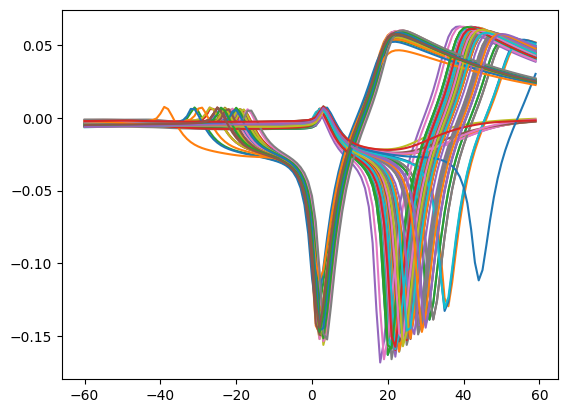

In [46]:
# this confirms these are the spike location we want to achieve
for spike_i in target_spike_loc:
    plt.plot(x_axis, cell_trace[71].iloc[spike_i-60:spike_i+60])

Come up with a better way to find spike location
- this allows a maximum of 1 shift in location of the sample in contrast with the previous methods which produces increasing shifts when location id increases.

### Plot waveforms with Spikeinterface pipeline

**Hypothesis**: the plotting function is wrong - YES -> corrected now.

2023-01-24 14:16:54,848 - root - utils.py - get_config - INFO - Loaded config
2023-01-24 14:17:04,403 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
2023-01-24 14:17:14,412 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


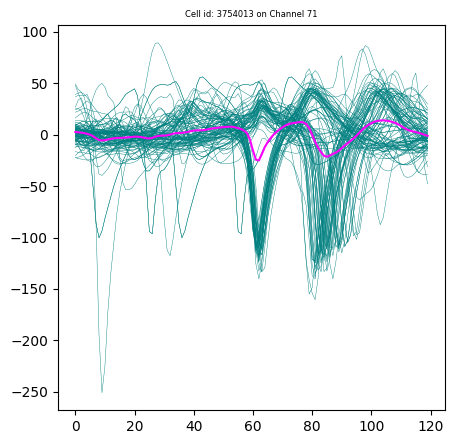

In [24]:
# # recreate sorting object and trace objects from scratch with target data
# # lfp_trace2 and target_spike_loc have been validated above with custom method
# import spikeinterface.extractors as se
# import probeinterface as pi
# import spikeinterface.postprocessing as spost
# from src.pipelines.simulation.dataeng.loading import load_campaign_params
# from src.nodes.utils import get_config
# import shutil
# from spikeinterface.comparison import GroundTruthStudy
# from src.pipelines.simulation.preprocessing import preprocess

# SIMULATION_DATE = "2023_01_13"
# MS_BEFORE = 3.0
# MS_AFTER = 3.0
# STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_study'

# # load parameters
# data_conf, param_conf = get_config(SIMULATION_DATE).values()
# simulation = load_campaign_params(data_conf, param_conf)

# # load data
# lfp_trace = pd.read_pickle(LFP_TRACE_FILE_PATH)
# spike = pd.read_pickle(SPIKE_FILE_PATH)

# # get cell's spike 
# spike_ms = spike[spike==CELL_ID]

# # Find spike locations as the closest times to trace times
# improved_spike_loc = []
# for spike_ms_i in spike_ms.index:
#     improved_spike_loc.append(np.abs(lfp_trace.index - spike_ms_i).argmin())

# # map spikes with units in SI's SortingObject
# times = np.array(improved_spike_loc)
# labels = np.tile(CELL_ID, len(times))

# SortingObject = se.NumpySorting.from_times_labels(
#     [times], [labels], simulation["lfp_sampling_freq"]
# )
# SortingObject = SortingObject.select_units([CELL_ID])

# # preprocess recording 
# lfp_recording = preprocess.run(data_conf, param_conf)

# # format trace, spike data
# gt_dict = {
#     'rec0': (lfp_recording, SortingObject),
# }

# # write study
# shutil.rmtree(STUDY_FOLDER, ignore_errors = True)
# study = GroundTruthStudy.create(STUDY_FOLDER, gt_dict)

# # compute waveforms
# study.compute_waveforms(lfp_recording)

# # setup waveform extractor
# waveform_extractor = study.get_waveform_extractor(lfp_recording)
# waveform_extractor.set_params(ms_before=MS_BEFORE, ms_after=MS_AFTER)
# waveform_extractor.run_extract_waveforms()



# # plot
# # ----
# colors = ["Olive", "Teal", "Fuchsia"]

# # get channels where spike amplitude is maximal
# max_chids = spost.get_template_extremum_channel(
#     waveform_extractor, peak_sign="both"
# )

# # get cell waveforms
# waveform = waveform_extractor.get_waveforms(CELL_ID)

# # set plot
# plt.figure(figsize=(5, 5))

# # plot waveform instances
# plt.plot(waveform[:, :, max_chids[CELL_ID]].T, color=colors[1], lw=0.3)

# # plot average waveform
# tmp = waveform_extractor.get_template(CELL_ID)
# plt.plot(tmp[:, max_chids[CELL_ID]], color=colors[2])
# plt.title(
#     f"Cell id: {CELL_ID} on Channel {max_chids[CELL_ID]}", fontsize=6
# )
# plt.show()

2023-01-24 14:32:07,829 - root - utils.py - get_config - INFO - Loaded config
2023-01-24 14:32:18,937 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
2023-01-24 14:32:28,732 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


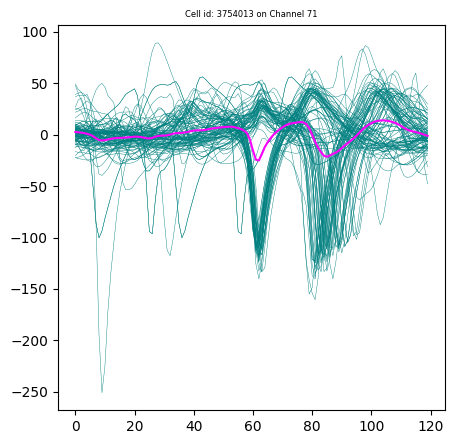

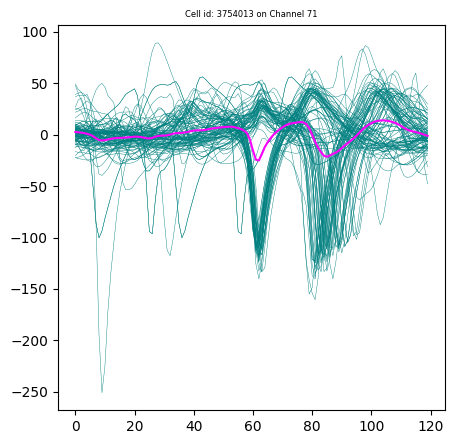

In [30]:
from src.pipelines.postprocessing import waveform_extraction 

waveform_extractor = waveform_extraction.run(simulation_date=SIMULATION_DATE,
    lfp_trace_file=LFP_TRACE_FILE_PATH,
    spike_file=SPIKE_FILE_PATH,
    cell_id=CELL_ID,
    study_folder=STUDY_FOLDER,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER
    )

waveform_extraction.plot(waveform_extractor=waveform_extractor, cell_id=CELL_ID)


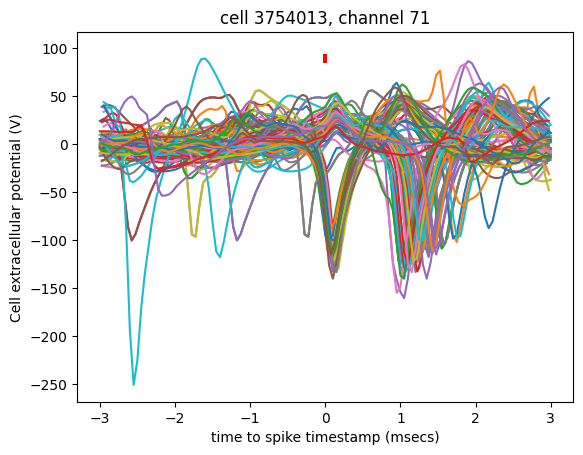

In [186]:
# just a reminder of the correct waveforms

# trace period
MIN_TIME = 0        # ms
MAX_TIME = 40000    # ms

# period around spike
MS_BEFORE = 3       # ms
MS_AFTER = 3        # ms
SAMPLING_FREQ = 20000

# compute and plot waveforms from lfp trace
out = get_waveforms(cell_id=CELL_ID, spikes=spike, trace=lfp_traces2_df, channel_id=CHANNEL_ID[0], ms_before=MS_BEFORE, ms_after=MS_AFTER, min_time=MIN_TIME, max_time=MAX_TIME)
plot_waveforms(out["spikes"], out["waveforms"], out["timestamps"], title=f"cell {CELL_ID}, channel {CHANNEL_ID[0]}", linelengths=10)
plt.show()

In [ ]:
# get target spike location
target_spike_loc = []
current_spike_loc = []
for ix in range(len(out["waveform_locations"])):
    target_spike_loc.append(out["waveform_locations"][ix][0] + 60)
    current_spike_loc.append(si_waveform_locations[ix][0] + 60)

np.array(target_spike_loc) - np.array(current_spike_loc)
target_spike_loc

In [255]:
# what is given:
spike_ms = spike[spike==CELL_ID]
spike_ms

t
549.825      3754013
551.025      3754013
604.100      3754013
605.200      3754013
1253.000     3754013
              ...   
38836.275    3754013
38837.625    3754013
39323.525    3754013
39878.875    3754013
39880.275    3754013
Name: gid, Length: 106, dtype: int64

In [273]:
target_spike_loc[15]

123369